In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [16]:
df = pd.read_csv('CN_DB.csv')
df.columns

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude'],
      dtype='object')

In [37]:
# calcualte the mean values for each city
# group by city, using mean values
df_city = df.groupby('city').agg(
    records=('city', 'size'),
    thermal_sensation=('thermal_sensation', 'mean'),
    ta=('ta', 'mean'),
    top=('top', 'mean'),
    tg=('tg', 'mean'),
    clo=('clo', 'mean'),
    latitude=('latitude', 'mean'),
).reset_index()

In [38]:
df_city.head()

,city,records,thermal_sensation,ta,top,tg,clo,latitude
0,Baotou,303,0.016502,19.766997,19.277228,19.180198,0.341782,40.65
1,Beijing,651,-0.027957,22.948541,22.066052,22.468971,0.920568,39.90
2,FujianFuzhou,7,-0.714286,18.100000,18.100000,18.100000,0.351429,26.08
3,FujianNanping,4,0.000000,17.900000,17.900000,17.900000,0.417500,26.64
4,FujianZhenjiang,2,-0.500000,22.900000,22.900000,22.900000,0.305000,26.10


## calcualte the neutral temperature for each city using three methods

In [39]:
def regression_a(df):
    """
    thermal_sensation = a * top + b
    Regressing Thermal Sensation Vote (thermal_sensation) against indoor operative temperature (top).    
    Use the regression model to derive the neutral temperature by letting thermal_sensation equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting thermal_sensation equals +-0.85.
    """
    lm_result = smf.ols(formula='thermal_sensation ~ top', data=df).fit()
    slope = lm_result.params['top']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['top'] < 0.05:
        a = slope
        b = intercept
        tn = -b / a
        tup = (0.85-b)/a
        tlow = (-0.85-b)/a
        comfz = tup - tlow
        return [tn, comfz]
    else:
        return [np.nan] * 2  # Return NaNs if the slope is not significant

def regression_b(df):
    """
    top = a * thermal_sensation + b
    Regressing indoor operative temperature (top) against thermal_sensation.
    Use the regression model to derive the neutral temperature by letting thermal_sensation equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting thermal_sensation equals +-0.85.
    """
    lm_result = smf.ols(formula='top ~ thermal_sensation', data=df).fit()
    slope = lm_result.params['thermal_sensation']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['thermal_sensation'] < 0.05:
        a = slope
        b = intercept
        tn = b
        tup = 0.85*a + b
        tlow = (-0.85)*a + b
        comfz = tup - tlow
        return [tn, comfz]
    else:
        return [np.nan] * 2
    
def griffiths(df):
    # Nicol, Fergus, and Michael Humphreys. “Derivation of the Adaptive Equations for Thermal Comfort in Free-Running Buildings in European Standard EN15251.” Building and Environment, International Symposium on the Interaction between Human and Building Environment Special Issue Section, 45, no. 1 (January 1, 2010): 11–17. https://doi.org/10.1016/j.buildenv.2008.12.013.
    # Griffths I. Thermal comfort studies in buildings with passive solar features, field studies. UK: Report of the Commission of the European Community, ENS35 090; 1990.
    # Tcomf = Tg - C / G, c as comfort vote and G as griffiths constatnt
    tn = df['tg'] - df['thermal_sensation'] / 0.4
    return tn


In [40]:
# apply regression_a to df for each city and store the results in the df_city
result = df.groupby('city').apply(regression_a)
df_result = pd.DataFrame(result.tolist(), index=result.index, columns=['tn_a', 'comfz_a'])
df_city = df_city.merge(df_result, left_on='city', right_index=True, how='left')

# apply regression_b to df for each city and store the results in the df_city
result = df.groupby('city').apply(regression_b)
df_result = pd.DataFrame(result.tolist(), index=result.index, columns=['tn_b', 'comfz_b'])
df_city = df_city.merge(df_result, left_on='city', right_index=True, how='left')
df_city

# directly apply griffiths to df for each city and store the results in the df_city
df_city['tn_g'] = df_city['tg'] - df_city['thermal_sensation'] / 0.4

In [42]:
# for all values in df_city, only keep two decimal places
df_city = df_city.round(2)
df_city 

,city,records,thermal_sensation,ta,top,tg,clo,latitude,tn_a,comfz_a,tn_b,comfz_b,tn_g
0,Baotou,303,0.02,19.77,19.28,19.18,0.34,40.65,18.99,29.22,19.26,1.57,19.14
1,Beijing,651,-0.03,22.95,22.07,22.47,0.92,39.90,22.26,11.95,22.11,2.53,22.54
2,FujianFuzhou,7,-0.71,18.10,18.10,18.10,0.35,26.08,NaN,NaN,NaN,NaN,19.89
3,FujianNanping,4,0.00,17.90,17.90,17.90,0.42,26.64,NaN,NaN,NaN,NaN,17.90
4,FujianZhenjiang,2,-0.50,22.90,22.90,22.90,0.31,26.10,NaN,NaN,NaN,NaN,24.15
5,GuangdongGuangzhou,997,-0.01,23.85,23.88,23.88,0.86,23.13,24.01,17.61,23.88,0.24,23.91
6,HainanSanya,5,0.60,24.88,24.88,24.88,0.33,18.25,NaN,NaN,NaN,NaN,23.38
7,HebeiHandan,26,-0.38,19.58,19.30,20.06,1.45,36.62,22.11,12.43,20.82,6.73,21.02
8,HeilongjiangHarbin,3552,0.29,23.09,22.71,21.38,0.92,45.75,20.86,10.69,22.41,1.71,20.65
9,HenanJiaozuo,888,-0.26,16.80,16.80,16.80,1.19,35.24,20.79,26.54,17.53,4.89,17.44


## Likelihood of Central Heating by City


In [43]:
# check the heating_type unique values
print(df['heating_type'].unique())

['Radiator heating' 'Convection heating' 'Radiant floor heating'
 'Naturally Ventilated' 'Ceiling capillary heating'
 'Air conditioning heating' 'Others' 'self-heating' 'Furnace heating'
 'Floor radiation + fan coil' 'Small electric heater heating']


In [44]:
# calcualte the percentage of Radiator heating for each city and assign the value to df_city
df_city['p_heating'] = df_city['city'].apply(lambda x: df[df['city'] == x]['heating_type'].value_counts().get('Radiator heating', 0) / df[df['city'] == x]['heating_type'].count())

In [45]:
# resort the df_city by latitude
df_city = df_city.sort_values(by='latitude')
# reset the index
df_city = df_city.reset_index(drop=True)
df_city

,city,records,thermal_sensation,ta,top,tg,clo,latitude,tn_a,comfz_a,tn_b,comfz_b,tn_g,p_heating
0,HainanSanya,5,0.60,24.88,24.88,24.88,0.33,18.25,NaN,NaN,NaN,NaN,23.38,0.000000
1,GuangdongGuangzhou,997,-0.01,23.85,23.88,23.88,0.86,23.13,24.01,17.61,23.88,0.24,23.91,0.000000
2,YunnanKunming,415,-1.15,13.62,13.62,19.22,0.65,24.87,19.97,9.36,15.28,2.44,22.10,0.000000
3,FujianFuzhou,7,-0.71,18.10,18.10,18.10,0.35,26.08,NaN,NaN,NaN,NaN,19.89,0.000000
4,FujianZhenjiang,2,-0.50,22.90,22.90,22.90,0.31,26.10,NaN,NaN,NaN,NaN,24.15,0.000000
5,FujianNanping,4,0.00,17.90,17.90,17.90,0.42,26.64,NaN,NaN,NaN,NaN,17.90,0.000000
6,HunanHengyang,1,-1.00,16.90,16.90,16.90,0.66,26.89,NaN,NaN,NaN,NaN,19.40,0.000000
7,HunanChangsha,1108,-0.40,17.22,17.41,18.20,0.95,28.23,21.35,16.92,18.09,2.91,19.19,0.000000
8,SichuanZigong,23,-0.22,11.03,11.03,11.03,1.59,29.34,11.54,3.99,11.14,0.91,11.57,0.000000
9,Lhasa,355,-1.10,10.64,10.64,10.64,1.25,29.65,20.98,16.03,12.12,2.29,13.38,0.005634


In [46]:
# save the df_city to a csv file
df_city.to_csv('CN_DB_RD.csv', index=False)

## Check p_heating values and update unreasonable ones

Text(0, 0.5, 'p_heating')

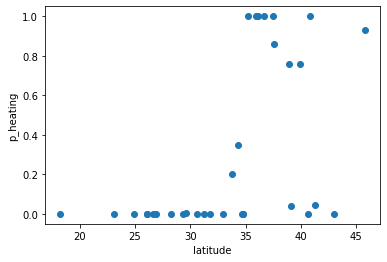

In [7]:
# scatter plot the p_heating across latitude
plt.scatter(df_city['latitude'], df_city['p_heating'])
plt.xlabel('latitude')
plt.ylabel('p_heating')

In [16]:
df_city['city'][15]

"ShaanxiXi'an"

In [18]:
# print each city name using a for loop
for i in range(len(df_city)):
    if i >= 15:
        cityname = df_city['city'][i]
        
        print(cityname)
        print(df_city['p_heating'][i])
        print(df[df['city'] == cityname]['heating_type'].value_counts())
        print(df[df['city'] == cityname]['building_type'].value_counts())
        print("***************************************\n")
        print()

ShaanxiXi'an
0.3469750889679715
Radiant floor heating    594
Radiator heating         585
Convection heating       507
Name: heating_type, dtype: int64
Office    1686
Name: building_type, dtype: int64
***************************************


HenanLuoyang
0.0
Convection heating      43
Naturally Ventilated     2
Name: heating_type, dtype: int64
Office         38
Residential     7
Name: building_type, dtype: int64
***************************************


HenanZhengzhou
0.0
Convection heating       92
Radiant floor heating     4
Name: heating_type, dtype: int64
Office         92
Residential     4
Name: building_type, dtype: int64
***************************************


HenanKaifeng
0.0
Naturally Ventilated    1
Name: heating_type, dtype: int64
Residential    1
Name: building_type, dtype: int64
***************************************


HenanJiaozuo
0.9988738738738738
Radiator heating        887
Naturally Ventilated      1
Name: heating_type, dtype: int64
Residential    888
Name: buildi

In [8]:
# Northern cities p_heating <1 but should be 1
for i in ["HenanJiaozuo", "ShandongYantai", "LiaoningDalian", "Tianjin", "Beijing", "Baotou", "LiaoningBenxi", "Turpan", "HeilongjiangHarbin"]:
    print(i)
    print(df[df['city'] == i]['heating_type'].value_counts())
    print(df[df['city'] == i]['building_type'].value_counts())
    print("***************************************\n")

HenanJiaozuo
Radiator heating        887
Naturally Ventilated      1
Name: heating_type, dtype: int64
Residential    888
Name: building_type, dtype: int64
***************************************

ShandongYantai
Radiator heating        6
Naturally Ventilated    1
Name: heating_type, dtype: int64
Residential    6
Office         1
Name: building_type, dtype: int64
***************************************

LiaoningDalian
Radiator heating         1292
Convection heating        278
Radiant floor heating      67
Furnace heating            58
Naturally Ventilated        8
Name: heating_type, dtype: int64
Office             1065
Dormitory           468
Residential         112
Rural residence      58
Name: building_type, dtype: int64
***************************************

Tianjin
Floor radiation + fan coil    684
Radiator heating               31
Convection heating             15
Name: heating_type, dtype: int64
Office    730
Name: building_type, dtype: int64
***********************************

In general, the "Radiator heating" should indicate central heating systems.</br>
However, for Northern cities, the "Raidiant floor heating", "Floor radiation + fan coil" should also indicate central heating systems.

In [ ]:
# replace the Baotou's p_heating value with 1, because of Hiayan's paper: http://dx.doi.org/10.1016/j.enbuild.2015.12.053
df_city.loc[df_city['city'] == 'Baotou', 'p_heating'] = 1
# replace Tian's p_heating value with (684+31)/(684+31+15), because of in office bulidngs, floor radiation + fan coil type should be central heat
df_city.loc[df_city['city'] == 'Tianjin', 'p_heating'] = (684+31)/(684+31+15)
# replace the LiaoningDalian's p_heating value with (684+31)/(684+31+15), because of radiant floor heating is supposed to be centralized
df_city.loc[df_city['city'] == 'LiaoningDalian', 'p_heating'] = (1292+67)/(684+31+15)

# replace the LiaoningBenxi's p_heating value with 1, because of radiant floor heating is supposed to be centralized
df_city.loc[df_city['city'] == 'LiaoningBenxi', 'p_heating'] = 1
# replace the HeilongjiangHarbin's p_heating value with 1, because of radiant floor heating is supposed to be centralized
df_city.loc[df_city['city'] == 'HeilongjiangHarbin', 'p_heating'] = 1


df_city[["city", "latitude", "p_heating"]]

In [32]:
# Cities nearby the boudnary p_heating 0 but should between 0 and 1
for i in ["HenanLuoyang", "HenanZhengzhou", "HenanKaifeng",]:
    print(i)
    print(df[df['city'] == i]['heating_type'].value_counts())
    print("***************************************\n")

HenanLuoyang
Convection heating      43
Naturally Ventilated     2
Name: heating_type, dtype: int64
***************************************

HenanZhengzhou
Convection heating       92
Radiant floor heating     4
Name: heating_type, dtype: int64
***************************************

HenanKaifeng
Naturally Ventilated    1
Name: heating_type, dtype: int64
***************************************



In [29]:
# Cities nearby the boudnary p_heating between 0 and 1
# ProfYan: nan yang can be 0
for i in ["ShaanxiXi'an", "HenanNanyang", "HenanPingdingshan"]:
    print(i)
    print(df[df['city'] == i]['heating_type'].value_counts())
    print("***************************************\n")

ShaanxiXi'an
Radiant floor heating    594
Radiator heating         585
Convection heating       507
Name: heating_type, dtype: int64
***************************************

HenanNanyang
Naturally Ventilated        155
Air conditioning heating     96
Name: heating_type, dtype: int64
***************************************

HenanPingdingshan
Naturally Ventilated    4
Radiator heating        1
Name: heating_type, dtype: int64
***************************************



In [ ]:
# p_heating for ShaanxiXi'an should also include Radiant floor heating